## Differential expression

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt

sc.settings.verbosity = 2      

In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
adata = sc.read_h5ad('./data/results/scanpy_clustered_covid.h5ad')

In [4]:
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:10])

(5589, 3058)
(5589, 18752)
  (0, 1)	0.90436876
  (0, 6)	0.90436876
  (1, 6)	0.9678403
  (2, 6)	0.5124039


In [5]:
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### 1. T-test

ranking genes
    finished (0:00:05)


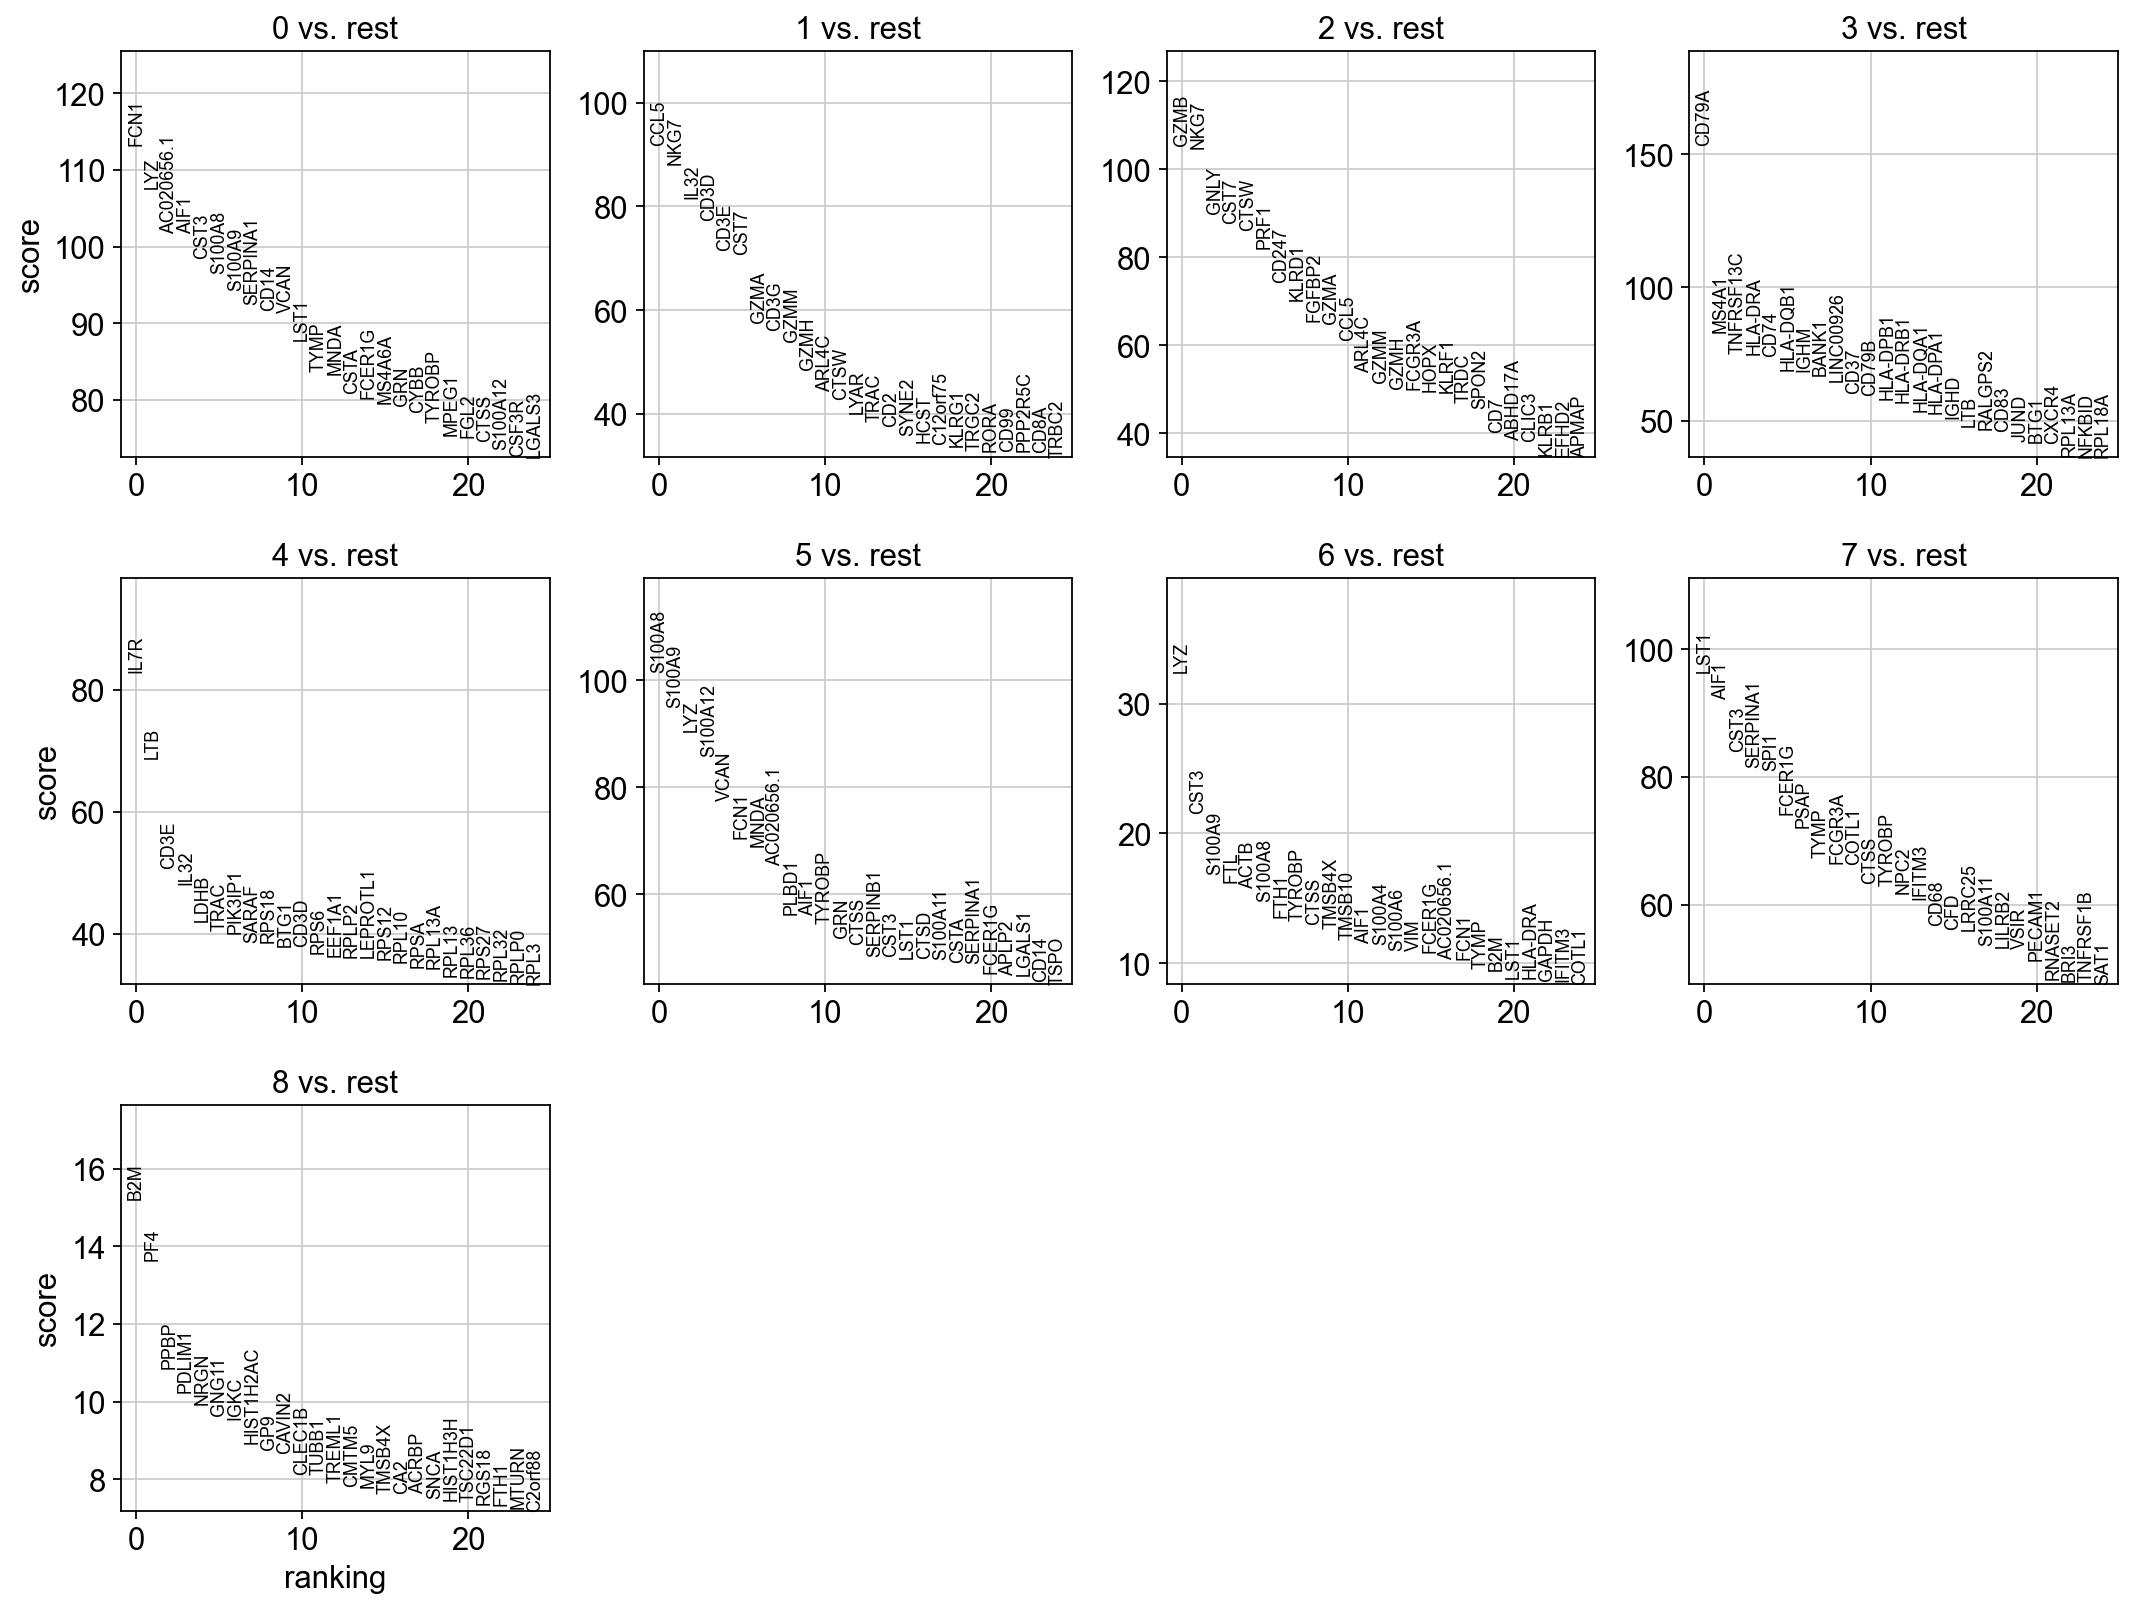

In [6]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")

### 2. T-test overestimated_variance

ranking genes
    finished (0:00:02)


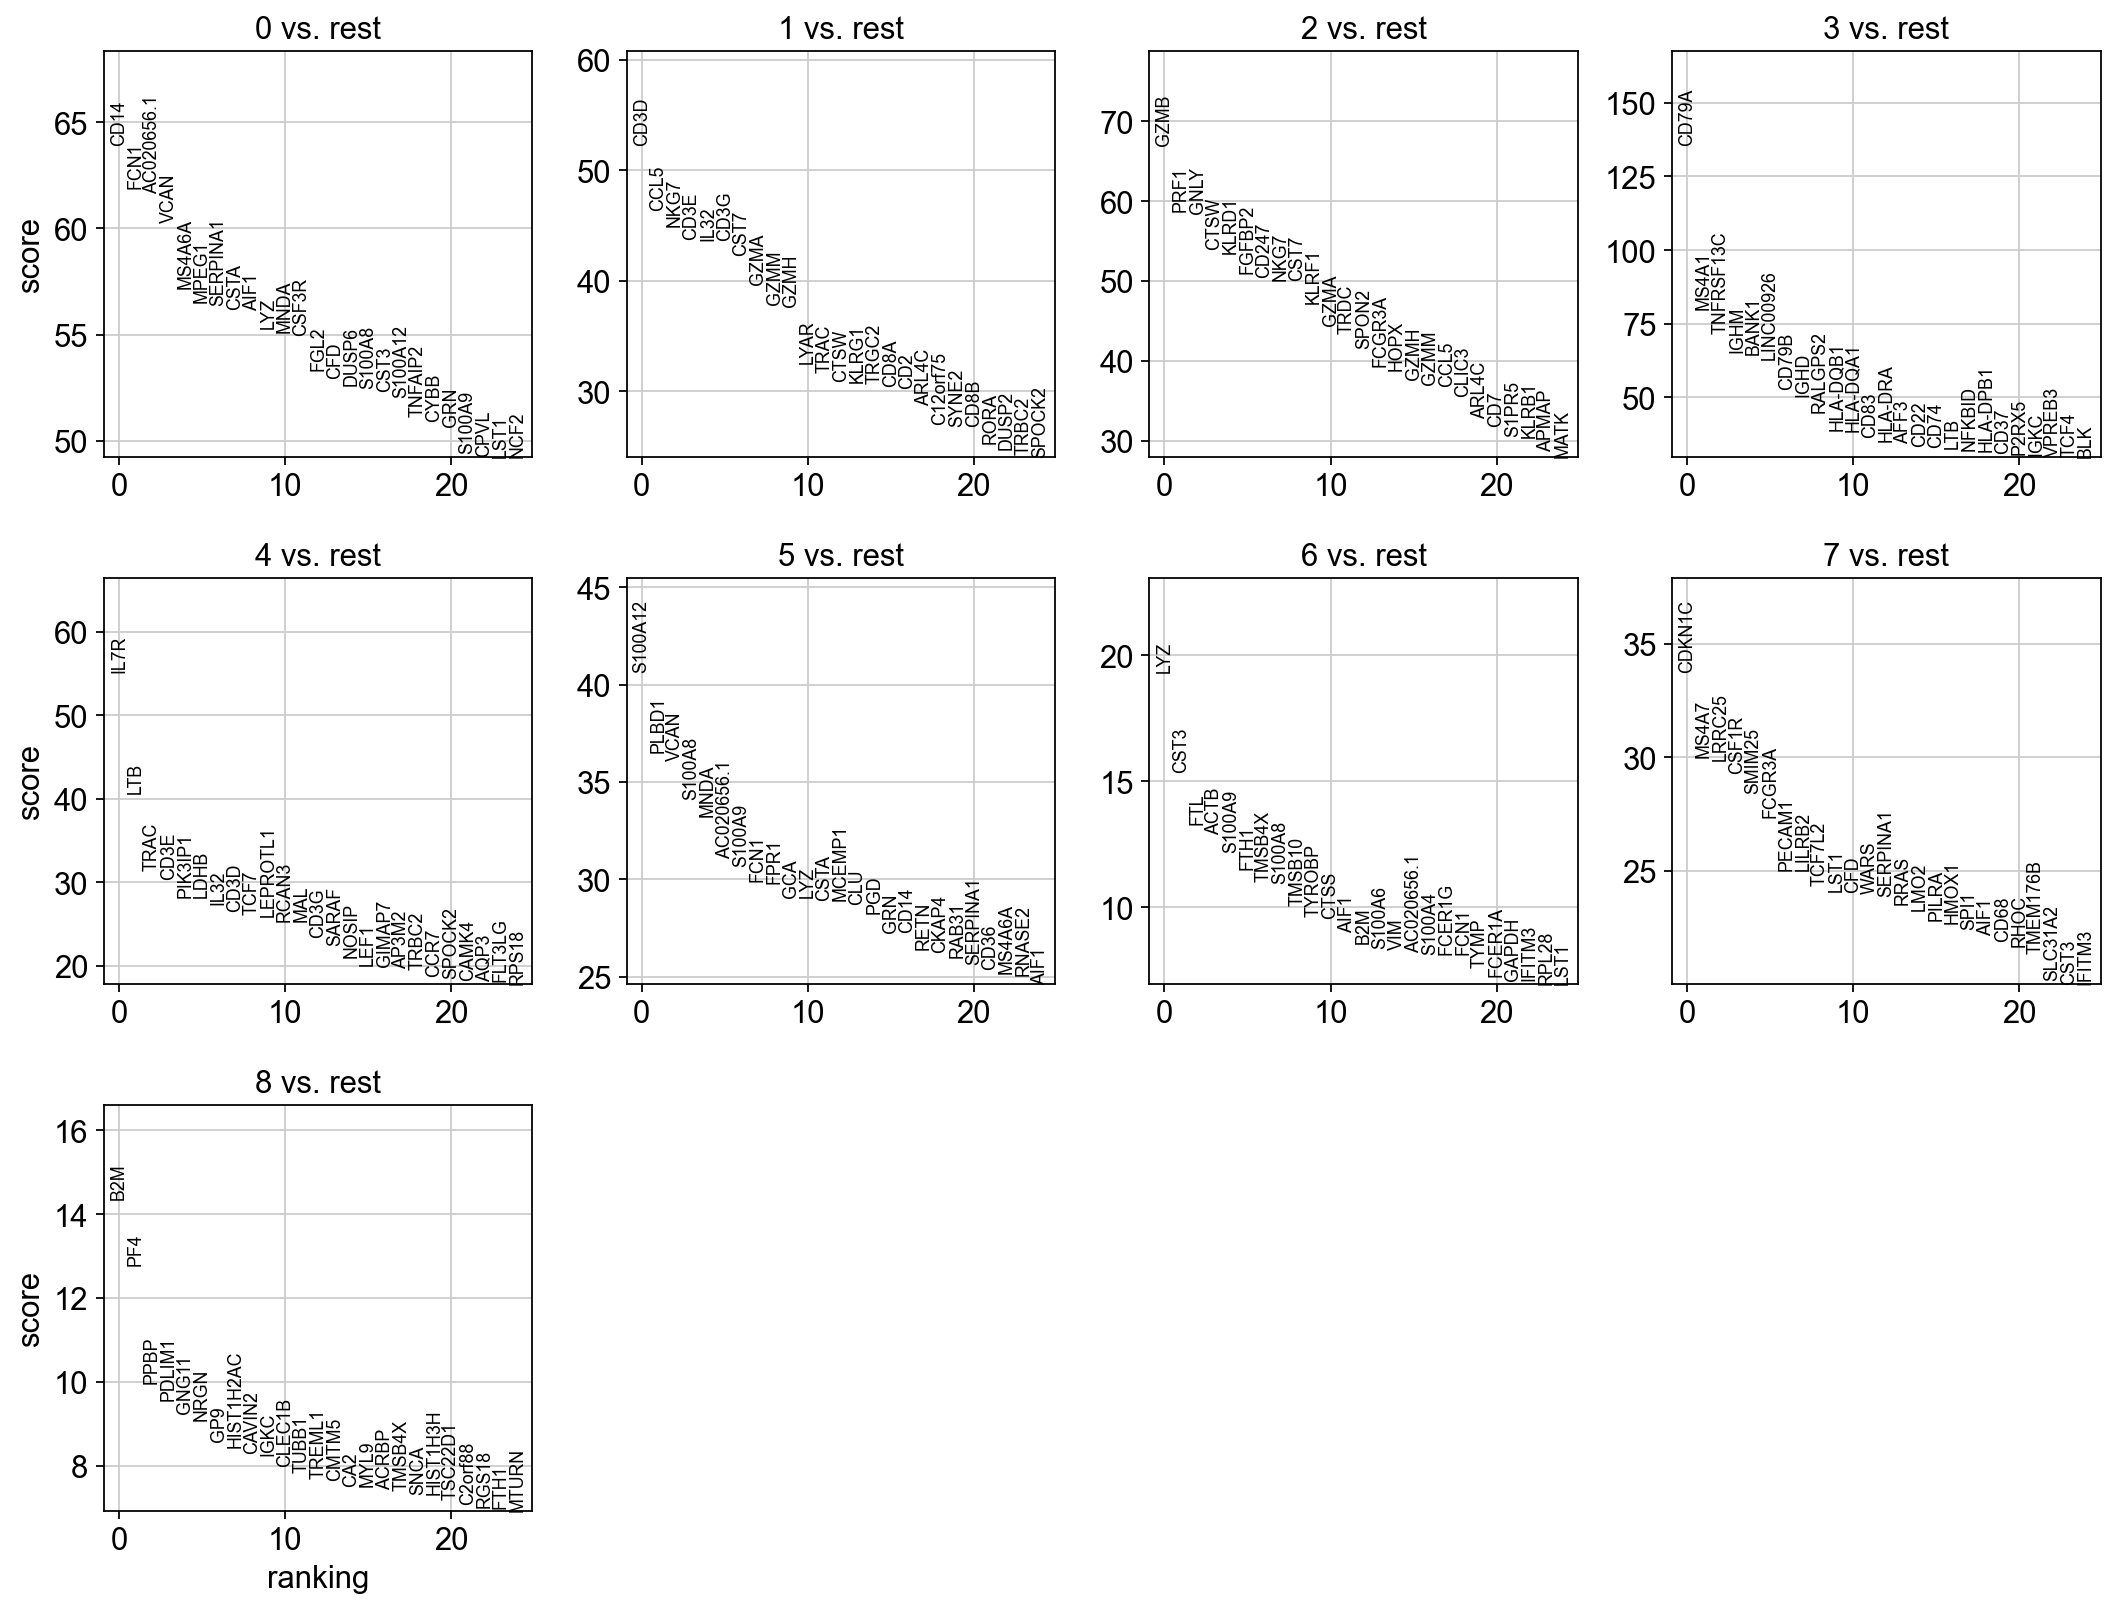

In [10]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key= "t-test_ov")

### 3. Wilcoxon rank-sum

In [ ]:
sc.